# Capital Cost of Compression

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator

import requests
from io import BytesIO

### Auxiliary Functions

In [2]:
def calculate_compression_power(
    specific_heat_cp,
    mass_flow_rate,
    gas_constant,
    inlet_temp,
    molar_mass,
    isentropic_efficiency,
    pressure_ratio_per_stage,
    compression_ratio,
):
    """
    Calculates the isentropic compression power requirement per stage.

    Args:
        specific_heat_cp (float): Molar specific heat at constant pressure.
        mass_flow_rate (float): Mass flow rate.
        gas_constant (float): Universal gas constant.
        inlet_temp (float): Inlet temperature.
        molar_mass (float): Molar mass of the gas.
        isentropic_efficiency (float): Isentropic efficiency of the compressor.
        pressure_ratio_per_stage (float): Pressure ratio per stage.
        compression_ratio (float): Molar specific heat at constant volume (cv).

    Returns:
        tuple: A tuple containing:
            - specific_heat_ratio (float): Coefficient of adiabatic expansion (Cp/Cv).
            - stage_power (float): Compression power per stage in kW.
    """
    # Coefficient of Adiabatic Expansion
    kappa = 1000 / (24 * 3600)
    specific_heat_ratio = specific_heat_cp / compression_ratio
    co2_specific_heat_ratio = (specific_heat_ratio - 1) / specific_heat_ratio

    # Calculate the power [kW]
    stage_power = (
        kappa
        * (
            mass_flow_rate
            * compression_ratio
            * gas_constant
            * inlet_temp
            / (co2_specific_heat_ratio * molar_mass * isentropic_efficiency)
        )
        * (pressure_ratio_per_stage**co2_specific_heat_ratio - 1)
    )

    return specific_heat_ratio, stage_power


def transform_dataframe(df, value_name):
    """
    Performs transformations on annual cost Dataframes.

    Args:
        df(pd.DataFrame): The DataFrame to be transformed.
        value_name(str): The new name for the value column.

    Returns:
        pd.DataFrame: The transformed DataFrame.
    """
    df = df.reset_index()
    df = df.melt(id_vars=["Years"], var_name="Original Column", value_name="Value")
    df[["Group", "Type"]] = df["Original Column"].str.split(" - ", expand=True)
    df.drop(columns=["Original Column"], inplace=True)
    df.rename(columns={"Value": value_name}, inplace=True)
    return df


def get_ylim(y_min, y_max):
    delta = 0.25 * (y_max - y_min)
    return (y_min - delta, y_max + delta)


def config_plot(ax, y_values, x_lim, title, leg_loc="upper right", x_multiplelocator=2):
    y_min, y_max = min(y_values), max(y_values)
    y_min_lim, y_max_lim = get_ylim(y_min, y_max)
    y_baseline = np.mean([y_min, y_min_lim])
    ax.set_ylim([y_min_lim, y_max_lim])

    ax.xaxis.set_major_locator(MultipleLocator(x_multiplelocator))
    ax.set_xlim(x_lim)

    # ax.grid(color="w", axis="y")
    ax.grid(axis="y", alpha=0.1)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc=leg_loc, fontsize="small")
    ax.set_title(title)


def plot_dataframes(df, list_of_companies, plot_config):
    """
    Generates a multi-subplot figure based on input DataFrame and a list of companies.

    Args:
        df (pd.DataFrame): The DataFrame containing the data to be plotted.
        list_of_companies (list): A list of company names used to select columns.
        plot_config (dict): A dictionary with plot-specific settings, including:
            - 'ylabel' (str): The label for the y-axis.
            - 'save_path' (str): The file path to save the generated plot.
            - 'colors' (dict): A dictionary mapping plot types (e.g., 'BAU') to colors.
    """
    fig, axs = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)
    axs = axs.flatten()

    for company_id, company_name in enumerate(list_of_companies):
        ax = axs[company_id]
        X = df.index.values
        y_values = np.array([])  # Initialize with an empty array

        for plot_type, color in plot_config["colors"].items():
            column_name = f"{company_name} - {plot_type}"
            data = df.loc[:, column_name].values
            y_values = np.concatenate((y_values, data))
            ax.plot(X, data, color=color, label=plot_type)

        config_plot(
            ax,
            y_values,
            x_lim=[2025 - 0.5, 2031 - 0.5],
            title=company_name,
            x_multiplelocator=1,
        )

        if company_id in [0, 3]:
            ax.set_ylabel(plot_config["ylabel"])

        if company_id >= 3:
            ax.set_xlabel("$t \\, [year]$")

    fig.savefig(plot_config["save_path"], dpi=600, bbox_inches="tight")

### Data Reading

In [3]:
# URL = "https://raw.githubusercontent.com/thiagoneye/costcaster/main/data/Forecast%20(MtCO2e).xlsx"
# response = requests.get(URL)

# df = pd.read_excel(BytesIO(response.content), engine="openpyxl")
df = pd.read_excel("../data/Forecast (MtCO2e).xlsx")

df.drop(columns="Unnamed: 0", inplace=True)
df.set_index("Years", inplace=True)
display(df)

list_of_companies = ["A-1", "C-1", "C-2", "P-1", "S-1", "S-2"]

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,1.341908,1.252185,1.320980,1.579306,1.519020,1.554676,13.513428,13.340975,13.302679,2.283988,2.074743,2.248368,23.632865,18.060261,23.264298,8.940516,9.801581,8.801084
2026,1.341908,1.242492,1.300379,1.579306,1.519730,1.530430,13.513428,13.317894,13.095216,2.283988,1.921093,2.213303,23.632865,17.756772,22.901478,8.940516,9.772826,8.663826
2027,1.341908,1.239475,1.280099,1.579306,1.519925,1.506562,13.513428,13.317618,12.890989,2.283988,1.776351,2.178785,23.632865,17.540634,22.544317,8.940516,9.788235,8.528709
2028,1.341908,1.238880,1.260135,1.579306,1.519972,1.483066,13.513428,13.319519,12.689947,2.283988,1.657053,2.144806,23.632865,17.448469,22.192726,8.940516,9.823698,8.395699
2029,1.341908,1.238803,1.240482,1.579306,1.519983,1.459937,13.513428,13.319376,12.492040,2.283988,1.569028,2.111357,23.632865,17.423024,21.846618,8.940516,9.856964,8.264763
2030,1.341908,1.238796,1.221136,1.579306,1.519985,1.437168,13.513428,13.318683,12.297220,2.283988,1.510201,2.078429,23.632865,17.418340,21.505907,8.940516,9.878516,8.135870


### Variables

In [4]:
inlet_pressure = 0.1  # Initial Pressure [MPa]
outlet_pressure = 7.38  # Compressor Outlet Pressure (Rename, now it's final) Po
num_stages = 4  # Number of Stages
molar_mass = 44.01  # Molar Mass of CO2 [kg/kmol]
gas_constant = 8.314  # Ideal Gas Constant [kJ/kmol*K]
inlet_temp = 313.15  # Inlet Temperature [K]
isentropic_efficiency = 0.82  # Compressor Isentropic Efficiency
mass_flow_rate = 25000  # CO2 Mass Flow Rate
temp_variation = 356  # Temperature Variation During Compression

compression_ratio_stage = [0.995, 0.986, 0.959, 0.875]  # Compression Ratio per Stage

# Energy Cost
energy_price = 0.0815  # Energy Price
capacity_factor = 0.8  # Capacity Factor

# Capital Cost
capital_recovery_factor = 0.1275  # Capital Recovery Factor

# Operational & Maintenance Cost
oem_maintenance_factor = 0.05  # OEM Maintenance Operating Factor

In [5]:
COLORS = {
    "History": mcolors.CSS4_COLORS["darkslategray"],
    "Reference": mcolors.CSS4_COLORS["mediumturquoise"],
    "DBM": mcolors.CSS4_COLORS["goldenrod"],
    "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
    "BAU": mcolors.CSS4_COLORS["indianred"],
}

### Analysis

In [6]:
kappa = 1000 / (24 * 3600)
pressure_ratio = outlet_pressure / inlet_pressure
pressure_ratio_per_stage = pressure_ratio ** (1 / num_stages)
specific_heat_cv = (
    13.946
    + (5.981e-2 * temp_variation)
    - (3.501e-5 * temp_variation**2)
    + (7.469e-9 * temp_variation**3)
) / 44.01
specific_heat_cp = (
    22.26
    + (5.981e-2 * temp_variation)
    - (3.501e-5 * temp_variation**2)
    + (7.469e-9 * temp_variation**3)
) / (44.01 * specific_heat_cv)

# Compression Power Requirement

stage_k = []
stage_power = []
for compression_ratio in compression_ratio_stage:
    k, power = calculate_compression_power(
        specific_heat_cp,
        mass_flow_rate,
        gas_constant,
        inlet_temp,
        molar_mass,
        isentropic_efficiency,
        pressure_ratio_per_stage,
        compression_ratio=compression_ratio,
    )
    stage_k.append(k)
    stage_power.append(power)

# Convertion to tCO2e

df = df * 1e6

# Carbon Capture Percentage

corrected_carbon_emissions = df.copy()
corrected_carbon_emissions = corrected_carbon_emissions * 0.76
display(corrected_carbon_emissions.round(0).astype(int))

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,1019850,951660,1003945,1200273,1154455,1181554,10270205,10139141,10110036,1735831,1576805,1708759,17960978,13725798,17680866,6794792,7449201,6688824
2026,1019850,944294,988288,1200273,1154995,1163127,10270205,10121600,9952364,1735831,1460031,1682110,17960978,13495147,17405123,6794792,7427348,6584508
2027,1019850,942001,972875,1200273,1155143,1144987,10270205,10121390,9797152,1735831,1350027,1655877,17960978,13330882,17133681,6794792,7439059,6481819
2028,1019850,941549,957702,1200273,1155179,1127130,10270205,10122834,9644360,1735831,1259360,1630053,17960978,13260836,16866471,6794792,7466011,6380731
2029,1019850,941490,942767,1200273,1155187,1109552,10270205,10122726,9493950,1735831,1192461,1604631,17960978,13241498,16603429,6794792,7491293,6281220
2030,1019850,941485,928064,1200273,1155188,1092248,10270205,10122199,9345887,1735831,1147753,1579606,17960978,13237938,16344490,6794792,7507672,6183261


### Power Requirement

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,10956,10223,10785,12894,12402,12693,110329,108921,108608,18647,16939,18356,192947,147451,189938,72994,80024,71855
2026,10956,10144,10617,12894,12408,12495,110329,108732,106914,18647,15684,18070,192947,144973,186976,72994,79789,70735
2027,10956,10120,10451,12894,12409,12300,110329,108730,105247,18647,14503,17788,192947,143208,184060,72994,79915,69631
2028,10956,10115,10288,12894,12410,12108,110329,108745,103605,18647,13529,17511,192947,142456,181189,72994,80204,68546
2029,10956,10114,10128,12894,12410,11919,110329,108744,101990,18647,12810,17238,192947,142248,178364,72994,80476,67477
2030,10956,10114,9970,12894,12410,11734,110329,108739,100399,18647,12330,16969,192947,142210,175582,72994,80652,66424


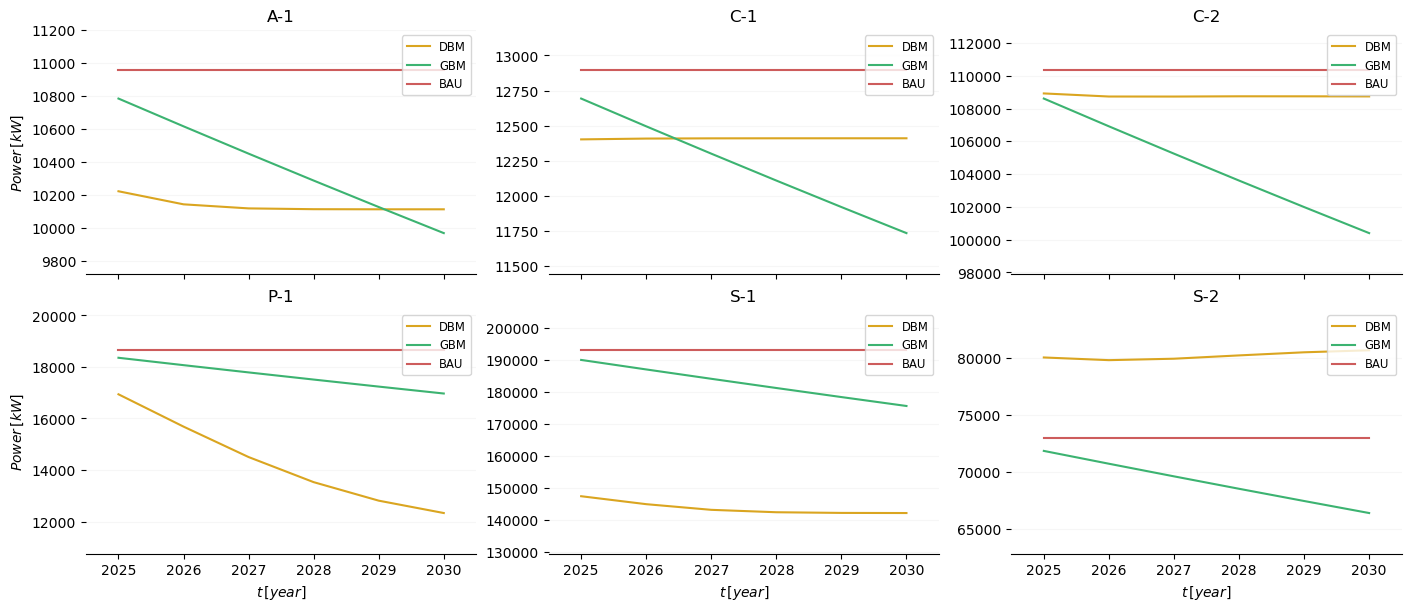

In [7]:
# Total Power Requirement [kW]

power_requirement = 0
for k, compression_ratio in zip(stage_k, compression_ratio_stage):
    # Calculates the power for the current stage
    power_per_stage = (
        (
            (corrected_carbon_emissions / 365)
            * compression_ratio
            * gas_constant
            * inlet_temp
            / (molar_mass * isentropic_efficiency)
        )
        * (k / (k - 1))
        * (pressure_ratio_per_stage ** (((k - 1) / k)) - 1)
    )

    # Totals the power
    power_requirement += power_per_stage

# Multiply the total result by the conversion factor
power_requirement *= kappa
display(power_requirement.round(0).astype(int))

# Plot

plot_power = {
    "ylabel": "$Power \\, [kW]$",
    "save_path": "../img/power_requirement.png",
    "colors": {
        "DBM": mcolors.CSS4_COLORS["goldenrod"],
        "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
        "BAU": mcolors.CSS4_COLORS["indianred"],
    },
}
plot_dataframes(power_requirement, list_of_companies, plot_power)

### Capital Cost of Compression

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,41940514,40800000,41678692,44752697,44064074,44473300,159749991,158934115,158752079,51839861,49892502,51516168,302857143,228847710,300965375,135495687,140554000,134649415
2026,43295193,41987660,42756324,46198209,45495815,45623169,164909916,163954472,162856067,53514288,49948900,52848080,312639429,234648886,308745895,139872198,144924073,138130446
2027,44693627,43301903,43861821,47690412,46967727,46802770,170236506,169248802,167066156,55242800,49977727,54214431,322737683,241048347,316727566,144390070,149699102,141701476
2028,46137232,44691998,44995904,49230812,48485389,48012871,175735145,174725479,171385089,57027142,50182513,55616110,333162110,248312176,324915592,149053869,154757319,145364831
2029,47627464,46134402,46159311,50820967,50051603,49254263,181411390,180368341,175815679,58869119,50688928,57054030,343923246,256183580,280364729,153868309,159971403,149122900
2030,49165831,47624440,47352801,52462484,51668297,50527753,187270978,186190378,180360815,60770592,51535536,58529130,355031967,264429967,287612534,158838255,165282308,152978130


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,3828,3991,3865,3471,3553,3504,1448,1459,1462,2780,2945,2806,1570,1552,1585,1856,1756,1874
2026,3952,4139,4027,3583,3667,3651,1495,1508,1523,2870,3185,2925,1620,1619,1651,1916,1816,1953
2027,4079,4279,4197,3699,3785,3805,1543,1557,1587,2963,3446,3048,1673,1683,1721,1978,1873,2035
2028,4211,4419,4374,3818,3907,3965,1593,1607,1654,3058,3709,3176,1727,1743,1793,2042,1930,2121
2029,4347,4561,4558,3941,4033,4132,1644,1659,1724,3157,3957,3310,1782,1801,1572,2108,1988,2210
2030,4488,4709,4750,4069,4164,4306,1697,1712,1796,3259,4180,3449,1840,1859,1638,2176,2049,2303


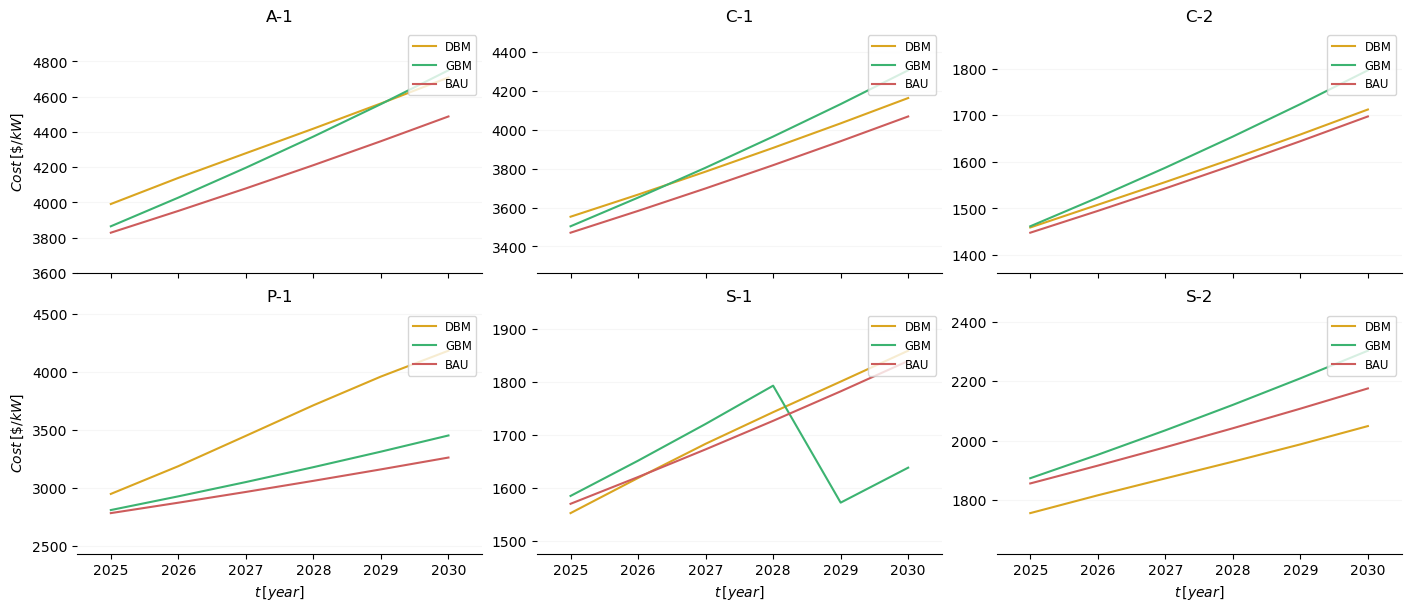

In [8]:
# Plant Cost Index

average_growth_ratio = 1.0323
ratio_between_years = 800 / 468.2  # f(2025)/f(2005)

temporal_cost_correction = np.zeros(len(df.index))
for idx in range(len(temporal_cost_correction)):
    if idx == 0:
        temporal_cost_correction[0] = ratio_between_years
    else:
        temporal_cost_correction[idx] = (
            temporal_cost_correction[idx - 1] * average_growth_ratio
        )

# Capital Cost ($)

c1 = 0.13 * (10**6)
c2 = 1.4 * (10**6)
v = kappa * (corrected_carbon_emissions / 365) / (np.ceil(power_requirement / 60000))

capital_cost = (
    kappa
    * (corrected_carbon_emissions / 365)  # mass_flow_rate
    * ((c1 / (v**0.71)) + (c2 * np.log(pressure_ratio) / (v**0.6)))
)

for idx, year in enumerate(df.index):
    capital_cost[capital_cost.index == year] *= temporal_cost_correction[idx]

display(capital_cost.round(0).astype(int))

# Capital Cost of Compression ($/kW)

capital_cost_per_power = capital_cost / power_requirement
display(capital_cost_per_power.round(0).astype(int))

# Plot

plot_cost = {
    "ylabel": "$Cost \\, [\$/kW]$",
    "save_path": "../img/capital_cost.png",
    "colors": {
        "DBM": mcolors.CSS4_COLORS["goldenrod"],
        "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
        "BAU": mcolors.CSS4_COLORS["indianred"],
    },
}
plot_dataframes(capital_cost_per_power, list_of_companies, plot_cost)

### Annual Compression Cost

In [9]:
# Annual Energy Cost ($)

energy_cost = power_requirement*energy_price*capacity_factor*24*365
display(energy_cost.round(0).astype(int))

# Annual Capital Cost ($)

corrected_cost_of_capital = capital_cost*capital_recovery_factor
display(corrected_cost_of_capital.round(0).astype(int))

# Annual O&M Cost ($)

oem_cost = capital_cost*oem_maintenance_factor
display(oem_cost.round(0).astype(int))

# Total Annual Cost ($)

total_cost = corrected_cost_of_capital + oem_cost + energy_cost
display(total_cost.round(0).astype(int))

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,6257440,5839052,6159852,7364449,7083329,7249597,63014359,62210193,62031615,10650445,9674719,10484345,110202226,84216658,108483561,41690449,45705672,41040263
2026,6257440,5793856,6063786,7364449,7086641,7136535,63014359,62102567,61064198,10650445,8958233,10320836,110202226,82801464,106791699,41690449,45571588,40400218
2027,6257440,5779788,5969218,7364449,7087549,7025237,63014359,62101279,60111868,10650445,8283289,10159877,110202226,81793589,105126223,41690449,45643441,39770154
2028,6257440,5777012,5876125,7364449,7087771,6915674,63014359,62110142,59174390,10650445,7726992,10001428,110202226,81363815,103486721,41690449,45808810,39149916
2029,6257440,5776651,5784483,7364449,7087819,6807821,63014359,62109477,58251532,10650445,7316521,9845450,110202226,81245163,101872788,41690449,45963931,38539351
2030,6257440,5776620,5694271,7364449,7087828,6701649,63014359,62106246,57343067,10650445,7042207,9691905,110202226,81223322,100284025,41690449,46064428,37938309


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,5347416,5202000,5314033,5705969,5618169,5670346,20368124,20264100,20240890,6609582,6361294,6568311,38614286,29178083,38373085,17275700,17920635,17167800
2026,5520137,5353427,5451431,5890272,5800716,5816954,21026014,20904195,20764149,6823072,6368485,6738130,39861527,29917733,39365102,17833705,18477819,17611632
2027,5698437,5520993,5592382,6080527,5988385,5967353,21705155,21579222,21300935,7043457,6372160,6912340,41149055,30733664,40382765,18409734,19086636,18066938
2028,5882497,5698230,5736978,6276929,6181887,6121641,22406231,22277499,21851599,7270961,6398270,7091054,42478169,31659802,41426738,19004368,19731558,18534016
2029,6072502,5882136,5885312,6479673,6381579,6279919,23129952,22996964,22416499,7505813,6462838,7274389,43850214,32663406,35746503,19618209,20396354,19013170
2030,6268643,6072116,6037482,6688967,6587708,6442289,23877050,23739273,22996004,7748250,6570781,7462464,45266576,33714821,36670598,20251878,21073494,19504712


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,2097026,2040000,2083935,2237635,2203204,2223665,7987500,7946706,7937604,2591993,2494625,2575808,15142857,11442386,15048269,6774784,7027700,6732471
2026,2164760,2099383,2137816,2309910,2274791,2281158,8245496,8197724,8142803,2675714,2497445,2642404,15631971,11732444,15437295,6993610,7246204,6906522
2027,2234681,2165095,2193091,2384521,2348386,2340138,8511825,8462440,8353308,2762140,2498886,2710722,16136884,12052417,15836378,7219503,7484955,7085074
2028,2306862,2234600,2249795,2461541,2424269,2400644,8786757,8736274,8569254,2851357,2509126,2780805,16658105,12415609,16245780,7452693,7737866,7268242
2029,2381373,2306720,2307966,2541048,2502580,2462713,9070570,9018417,8790784,2943456,2534446,2852702,17196162,12809179,14018236,7693415,7998570,7456145
2030,2458292,2381222,2367640,2623124,2583415,2526388,9363549,9309519,9018041,3038530,2576777,2926456,17751598,13221498,14380627,7941913,8264115,7648907


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,13701882,13081052,13557820,15308053,14904702,15143607,91369983,90420998,90210109,19852020,18530638,19628465,163959369,124837126,161904915,65740933,70654007,64940534
2026,13942337,13246666,13653033,15564632,15162148,15234648,92285869,91204486,89971150,20149231,17824163,19701370,165695724,124451641,161594095,66517764,71295611,64918372
2027,14190559,13465876,13754691,15829497,15424320,15332729,93231339,92142941,89766110,20456042,17154336,19782938,167488164,124579671,161345366,67319686,72215032,64922166
2028,14446799,13709841,13862897,16102918,15693927,15437959,94207348,93123914,89595243,20772762,16634388,19873287,169338500,125439226,161159239,68147511,73278234,64952173
2029,14711315,13965508,13977761,16385171,15971978,15550452,95214881,94124857,89458815,21099713,16313805,19972540,171248602,126717748,151637528,69002074,74358855,65008666
2030,14984376,14229958,14099393,16676540,16258951,15670325,96254958,95155038,89357112,21437225,16189764,20080825,173220400,128159642,151335250,69884239,75402038,65091927


In [10]:
# Transformation of Dataframes

corrected_cost_of_capital = transform_dataframe(corrected_cost_of_capital, "Cap")
oem_cost = transform_dataframe(oem_cost, "OEM")
energy_cost = transform_dataframe(energy_cost, "Power")

# Merging Dataframes

annual_cost = pd.merge(corrected_cost_of_capital, oem_cost, on=["Years", "Group", "Type"], how="outer")
annual_cost = pd.merge(
    annual_cost, energy_cost, on=["Years", "Group", "Type"], how="outer"
)
annual_cost = annual_cost.loc[:, ["Group", "Type", "Years", "Cap", "OEM", "Power"]]
display(annual_cost)

,Group,Type,Years,Cap,OEM,Power
0,A-1,BAU,2025,5.347416e+06,2.097026e+06,6.257440e+06
1,A-1,DBM,2025,5.202000e+06,2.040000e+06,5.839052e+06
2,A-1,GBM,2025,5.314033e+06,2.083935e+06,6.159852e+06
3,C-1,BAU,2025,5.705969e+06,2.237635e+06,7.364449e+06
4,C-1,DBM,2025,5.618169e+06,2.203204e+06,7.083329e+06
...,...,...,...,...,...,...
103,S-1,DBM,2030,3.371482e+07,1.322150e+07,8.122332e+07
104,S-1,GBM,2030,3.667060e+07,1.438063e+07,1.002840e+08
105,S-2,BAU,2030,2.025188e+07,7.941913e+06,4.169045e+07
106,S-2,DBM,2030,2.107349e+07,8.264115e+06,4.606443e+07


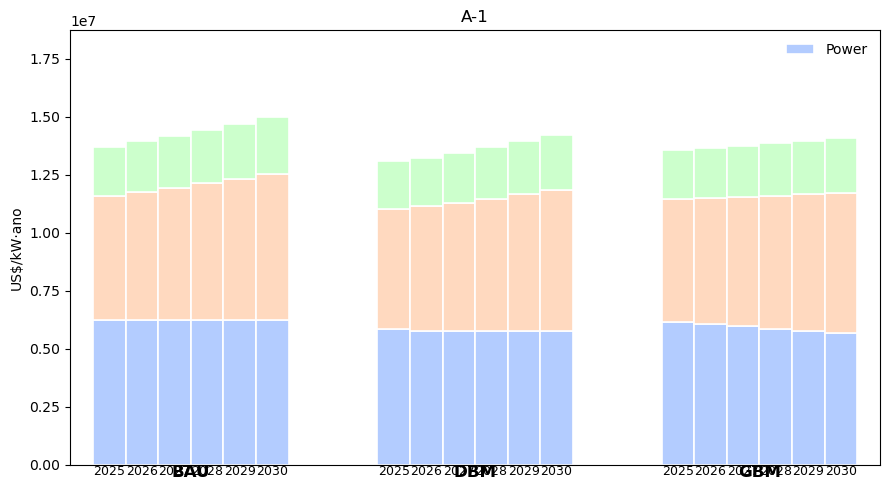

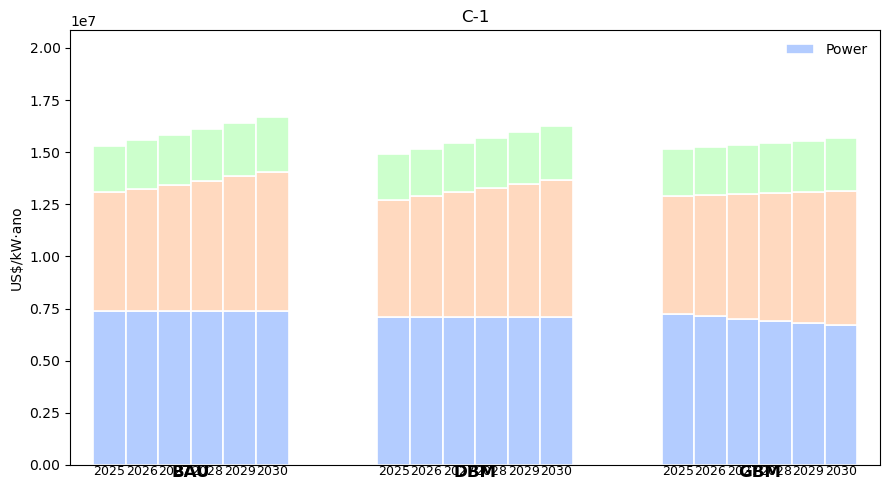

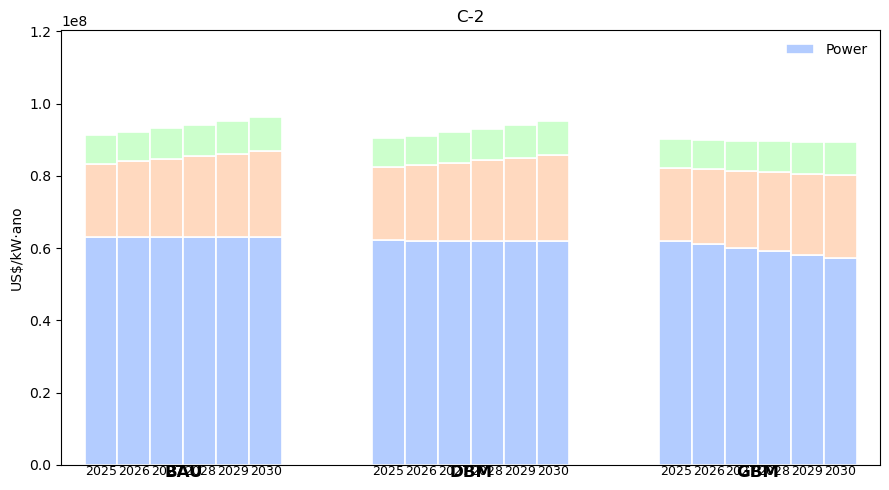

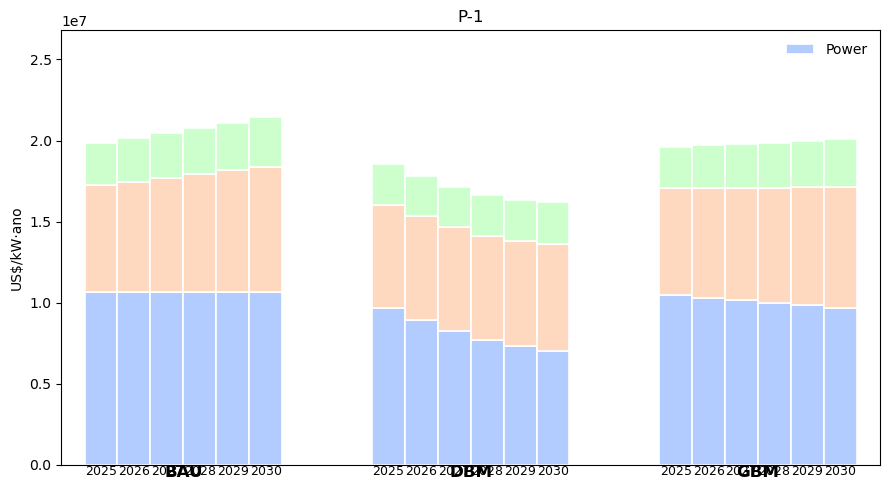

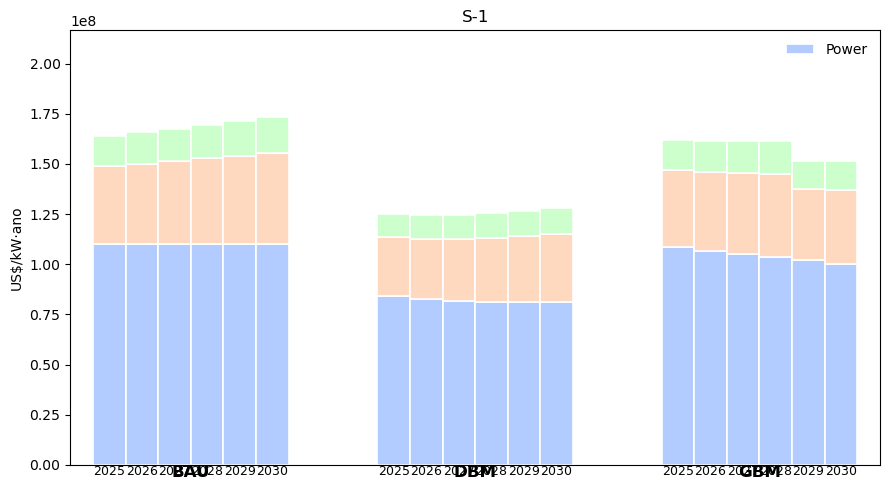

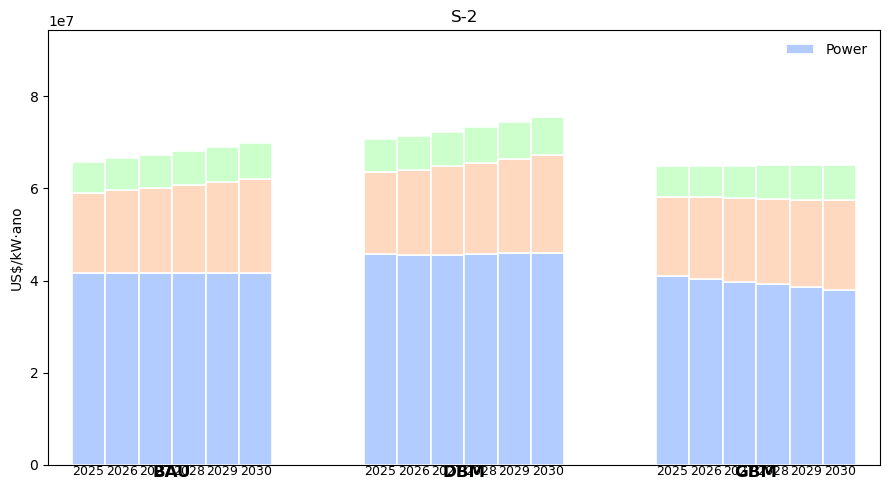

In [11]:
# Parâmetros do layout
scenarios = ["BAU", "DBM", "GBM"]
years = annual_cost.Years.unique()
n_years = len(years)
bar_width = 0.22  # largura de cada barra (ano) dentro do grupo
gap = 0.60  # espaço entre grupos de cenários

# Posições dos grupos no eixo X
group_pos = np.arange(len(scenarios)) * (n_years * bar_width + gap)

# Cores suaves e rótulos das fatias
colors = [(0.70, 0.80, 1.00), (1.00, 0.85, 0.75), (0.80, 1.00, 0.80)]
labels = ["Power", "Cap", "OEM"]

for company_name in list_of_companies:
    annual_cost_filtered = annual_cost[annual_cost["Group"] == company_name]

    # -----------------------
    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))

    for i, scen in enumerate(scenarios):
        subset = annual_cost_filtered[annual_cost_filtered["Type"] == scen]
        for j, year in enumerate(years):
            vals = subset[subset["Years"] == year][["Power", "Cap", "OEM"]].values[0]
            x = group_pos[i] + j * bar_width
            bottom = 0.0
            for k, val in enumerate(vals):
                ax.bar(
                    x,
                    val,
                    width=bar_width,
                    bottom=bottom,
                    color=colors[k],
                    edgecolor="white",
                    linewidth=1.2,
                    label=labels[k] if (i == 0 and j == 0 and k == 0) else None,
                )
                bottom += val
            # rótulo do ano sob cada barra
            ax.text(x, -6, year, ha="center", va="top", fontsize=9)

    # rótulo do cenário centralizado sob cada grupo
    for i, scen in enumerate(scenarios):
        xpos = group_pos[i] + (n_years - 1) * bar_width / 2
        ax.text(xpos, -50, scen, ha="center", va="top", fontsize=12, fontweight="bold")

    ax.set_ylabel("US$/kW·ano")
    ax.set_xticks([])  # tiramos ticks do x (usamos textos personalizados)
    ax.set_ylim(0, annual_cost_filtered[["Power", "Cap", "OEM"]].sum(axis=1).max() * 1.25)
    ax.margins(x=0.03)
    ax.legend(title="", loc="upper right", frameon=False)

    ax.set_title(company_name)

    plt.tight_layout()
    # Salvar figura (opcional)
    # plt.savefig("grouped_stacked_bars.png", dpi=200, bbox_inches="tight")
    plt.show()